# Preprocessing and clustering

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/anna.schaar/opt/miniconda3/envs/scverse_hackathon/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


The data used in this basic preprocessing and clustering tutorial was collected from bone marrow mononuclear cells of a healthy human donor and was part of Proceedings of the Neural Information Processing Systems Track on Datasets and Benchmarks 1 (NeurIPS Datasets and Benchmarks 2021) (Lücken et al. 2021, A sandbox for prediction and integration of DNA, RNA, and proteins in single cells). The sample used in this tutorial was measured using the 10X Multiome Gene Expression and Chromatin Accessability kit OR 10X 3' Single-Cell Gene Expression kit with Feature Barcoding in combination with the BioLegend TotalSeq B Universal Human Panel v1.0. (!!ToDo adjust after be picked the final sample)


We are reading in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data.

In [3]:
adata = sc.read_10x_h5('filtered_feature_bc_matrix.h5')

reading filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/anna.schaar/opt/miniconda3/envs/scverse_hackathon/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata.var_names_make_unique()

In [5]:
adata

AnnData object with n_obs × n_vars = 8785 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

The data contains 8,785 cells and 36,601 measured genes. This tutorial includes a basic preprocessing and clustering workflow. 

## Quality Control

The scanpy function `sc.pp.calculate_qc_metrics` calculates common quality control (QC) metrics, which are largely based on `calculateQCMetrics` from scater [McCarthy17]. One can pass specific gene popula

In QC, the first step is to calculate the QC covariates or metric. We compute these using the scanpy function sc.pp.calculate_qc_metrics, which can also calculate the proportions of counts for specific gene populations. We therefore define mitochondrial, ribosomal and hemoglobin genes. It is important to note that mitochondrial counts are annotated either with the prefix “mt-” or “MT-” depending on the species considered in the dataset. As mentioned, the dataset used in this notebook is human bone narrow, so mitochondrial counts are annotated with the prefix “MT-”. For mouse datasets, the prefix is usually lower case, so “mt-“.

In [7]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

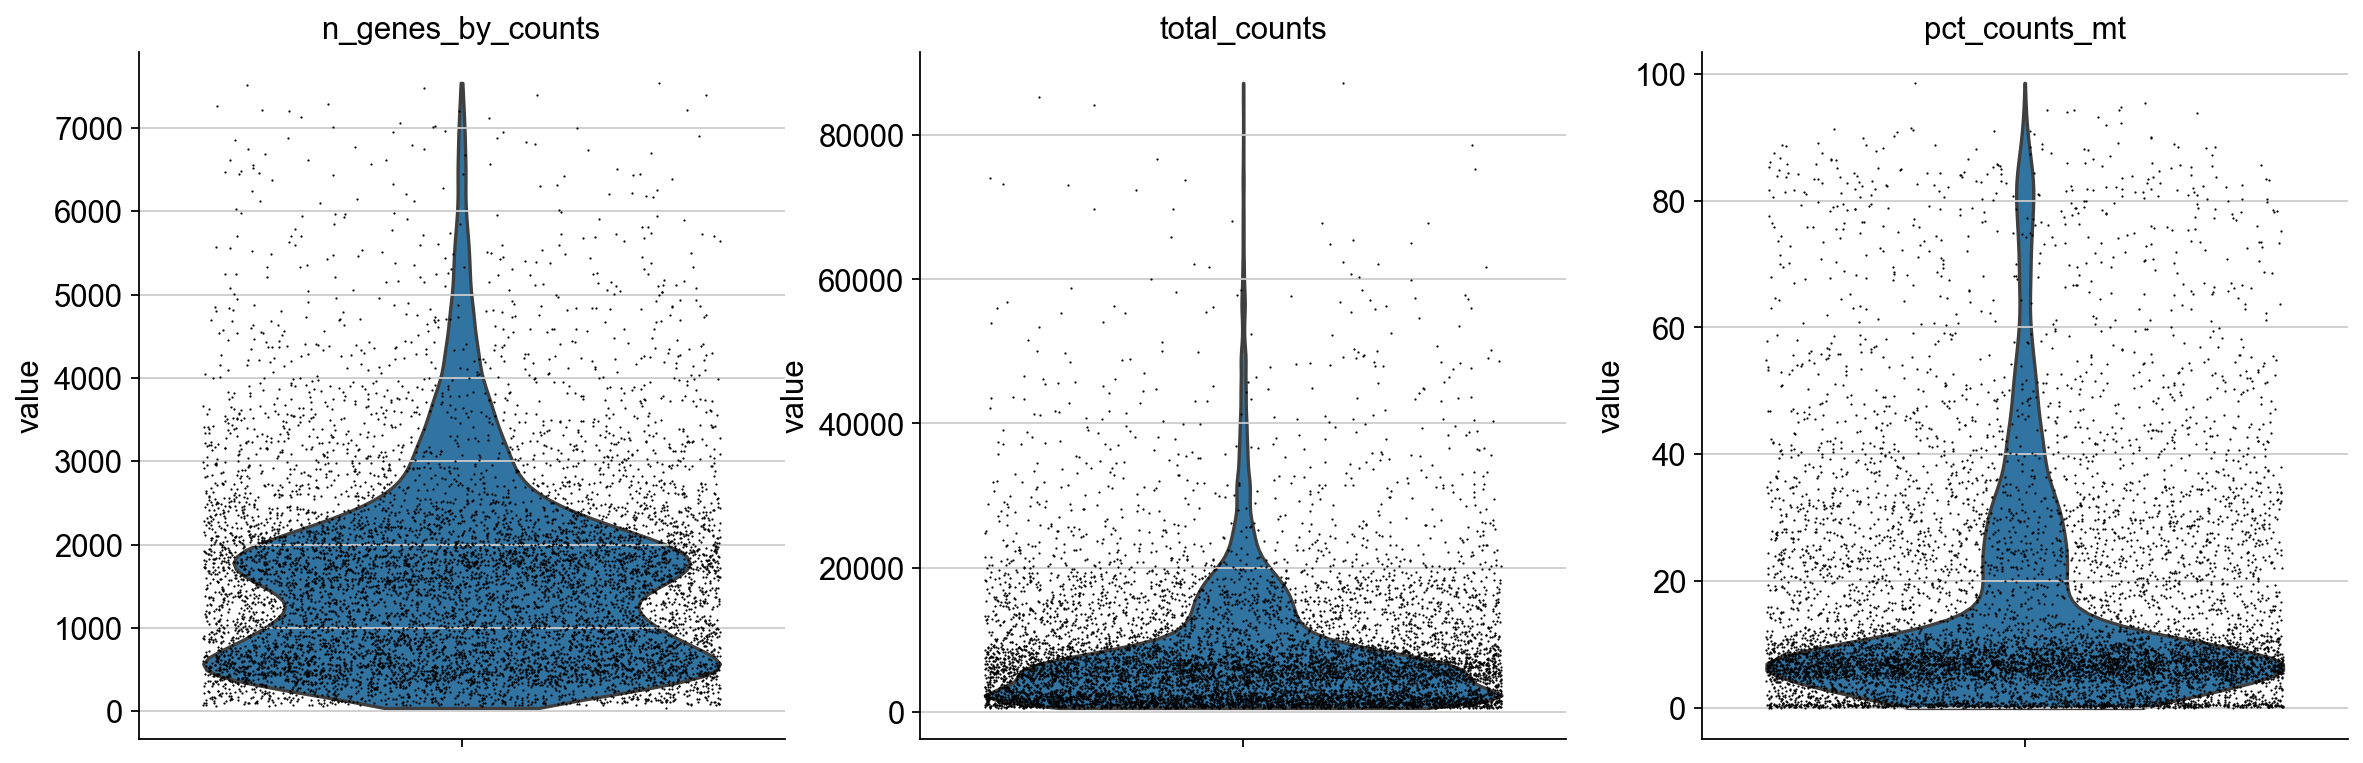

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

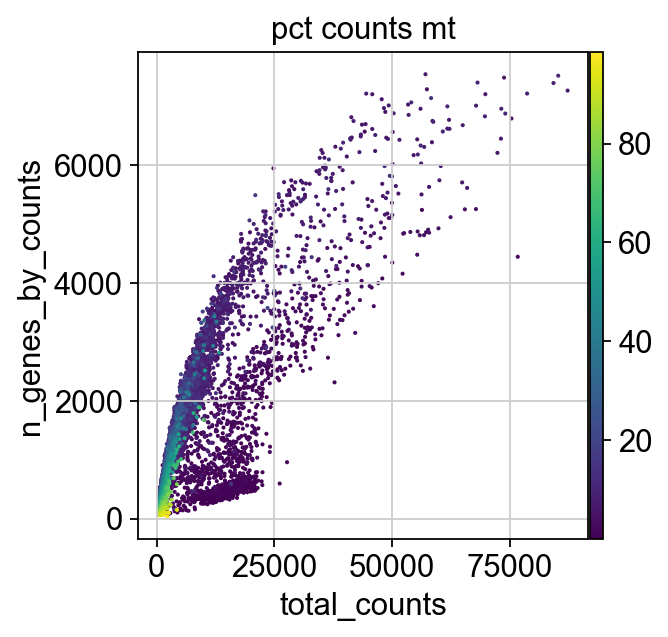

In [10]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 72 cells that have less than 100 genes expressed
filtered out 14926 genes that are detected in less than 3 cells


### Doublet detection

In [12]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/Users/anna.schaar/opt/miniconda3/envs/scverse_hackathon/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 28.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.4%
    Scrublet finished (0:00:12)


## Normalization

In [13]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Feature selection

In [14]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


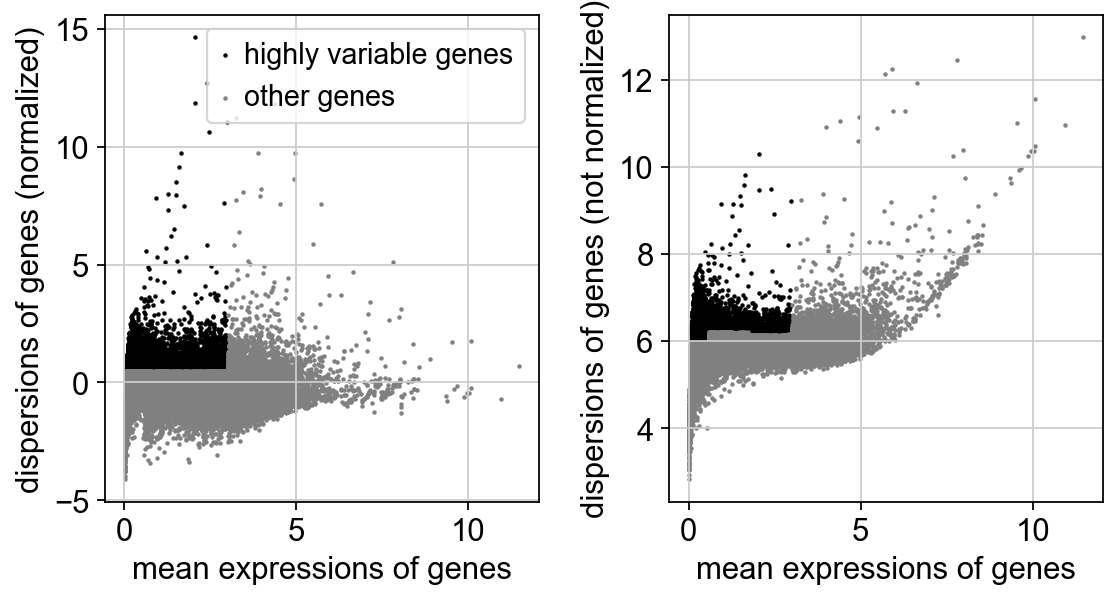

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
adata = adata[:, adata.var.highly_variable]

### Scaling 

In [17]:
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/anna.schaar/opt/miniconda3/envs/scverse_hackathon/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Dimensionality Reduction

In [18]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


/Users/anna.schaar/opt/miniconda3/envs/scverse_hackathon/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


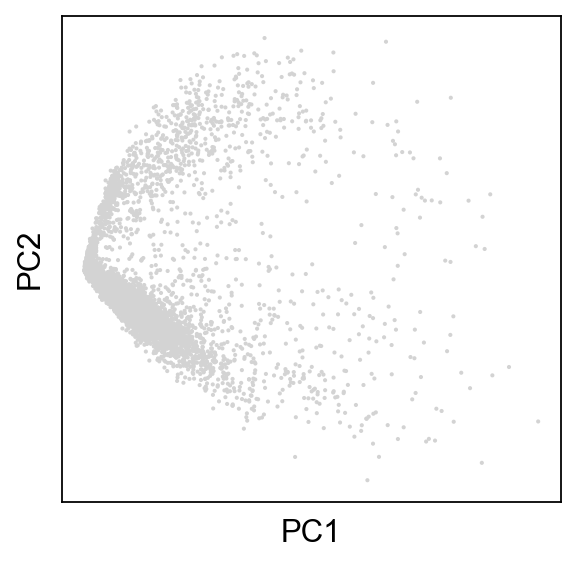

In [19]:
sc.pl.pca(adata)

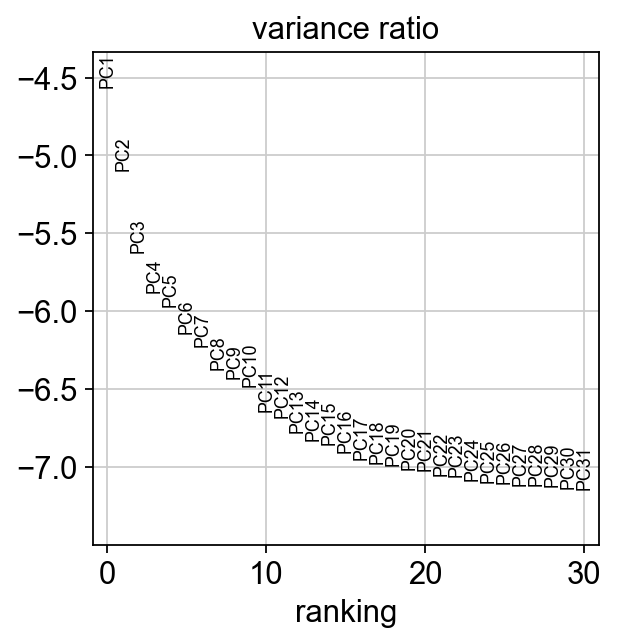

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)

## Visualization

In [21]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [22]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


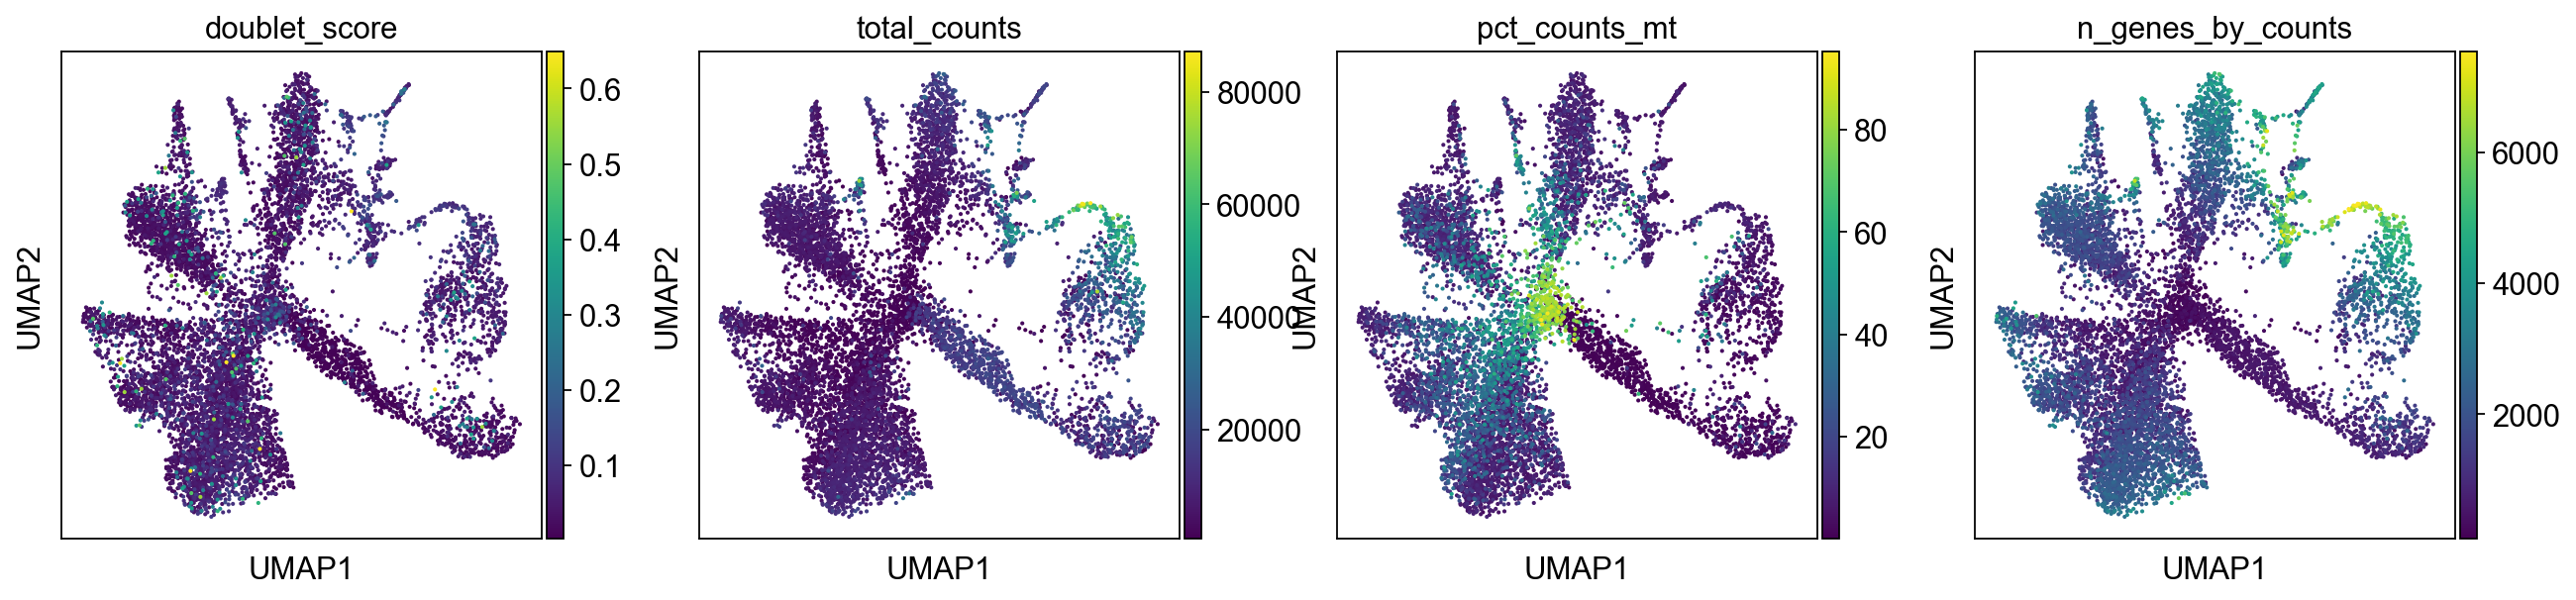

In [23]:
sc.pl.umap(adata, color=['doublet_score', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts'])

In [24]:
adata

AnnData object with n_obs × n_vars = 8713 × 4744
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Clustering

In [26]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/anna.schaar/opt/miniconda3/envs/scverse_hackathon/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


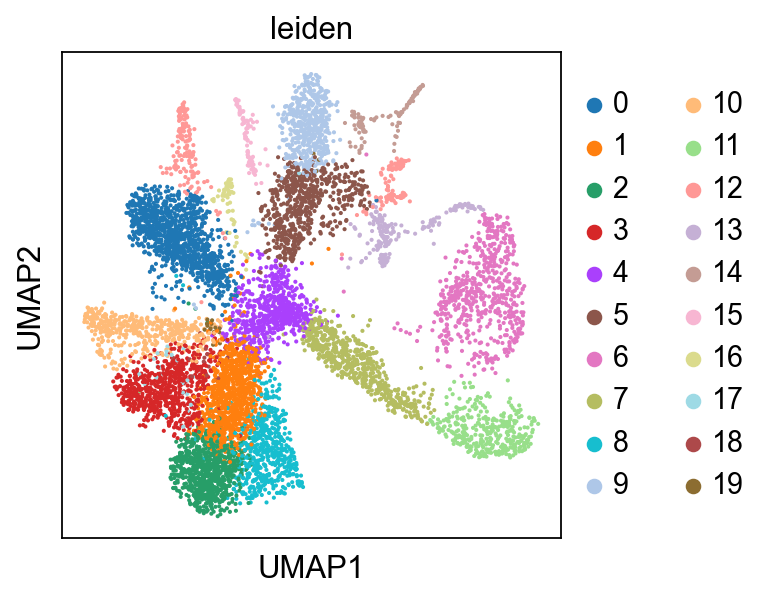

In [27]:
sc.pl.umap(adata, color=['leiden'])